## Pneumonia Detection from Chest X-ray Images

<p align="center">
   <img width="621" alt="Screenshot 2021-02-07 at 17 30 12" src="https://user-images.githubusercontent.com/76659596/107152793-30234600-696a-11eb-8827-56cb0c3a7578.png">
</p>

In this notebook, a `Convolutional Neural Network (CNN)` has been developed and trained to select the presence of `pneumonia` disease by analyzing chest X-ray images.

This is a `binary classification` problem where the outcome is either a person has `pneumonia` disease or not (`normal` condition).

This model is built from scratch, i.e. not relying on transfer learning approaches (pre-trained models).

### Import Libraries

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline

from texttable import Texttable

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, \
    Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Configurations

In [2]:
MODEL_LOC = '../model/pneumonia_detection_cnn_model.h5'
DATA_DIR = './chest_xray/'
TRAINING_DATA_DIR = DATA_DIR + 'train/'
TEST_DATA_DIR = DATA_DIR + 'test/'
VAL_DATA_DIR = DATA_DIR + 'val/'
DETECTION_CLASSES = ('NORMAL', 'PNEUMONIA')
BATCH_SIZE = 32
EPOCHS = 20

### Exploratory Data Analysis (EDA)

In [3]:
# counting the number of images for every dataset and the associated two classes (Normal and Pneumonia)
def count_images(directory_name, detection_class):
    return len(os.listdir(directory_name + detection_class))

t = Texttable()

t.add_rows([['Dataset Type', 'Normal', 'Pneumonia'], 
            ['Training', count_images(TRAINING_DATA_DIR, 'NORMAL'), count_images(TRAINING_DATA_DIR, 'PNEUMONIA')], 
            ['Test', count_images(TEST_DATA_DIR, 'NORMAL'), count_images(TEST_DATA_DIR, 'PNEUMONIA')],
            ['Validation', count_images(VAL_DATA_DIR, 'NORMAL'), count_images(VAL_DATA_DIR, 'PNEUMONIA')]
           ])
print(t.draw())

+--------------+--------+-----------+
| Dataset Type | Normal | Pneumonia |
+==============+========+===========+
| Training     | 1341   | 3875      |
+--------------+--------+-----------+
| Test         | 234    | 390       |
+--------------+--------+-----------+
| Validation   | 8      | 8         |
+--------------+--------+-----------+


As can be seen from the above data exploration, the data is highly imbalanced. That is, the number of images for `pneumonia` cases are much higher than the `normal` cases. However, this is expected in the medical data, as a person is advised to have the X-ray done if some symptoms are noticed and hence more likely to have the disease.

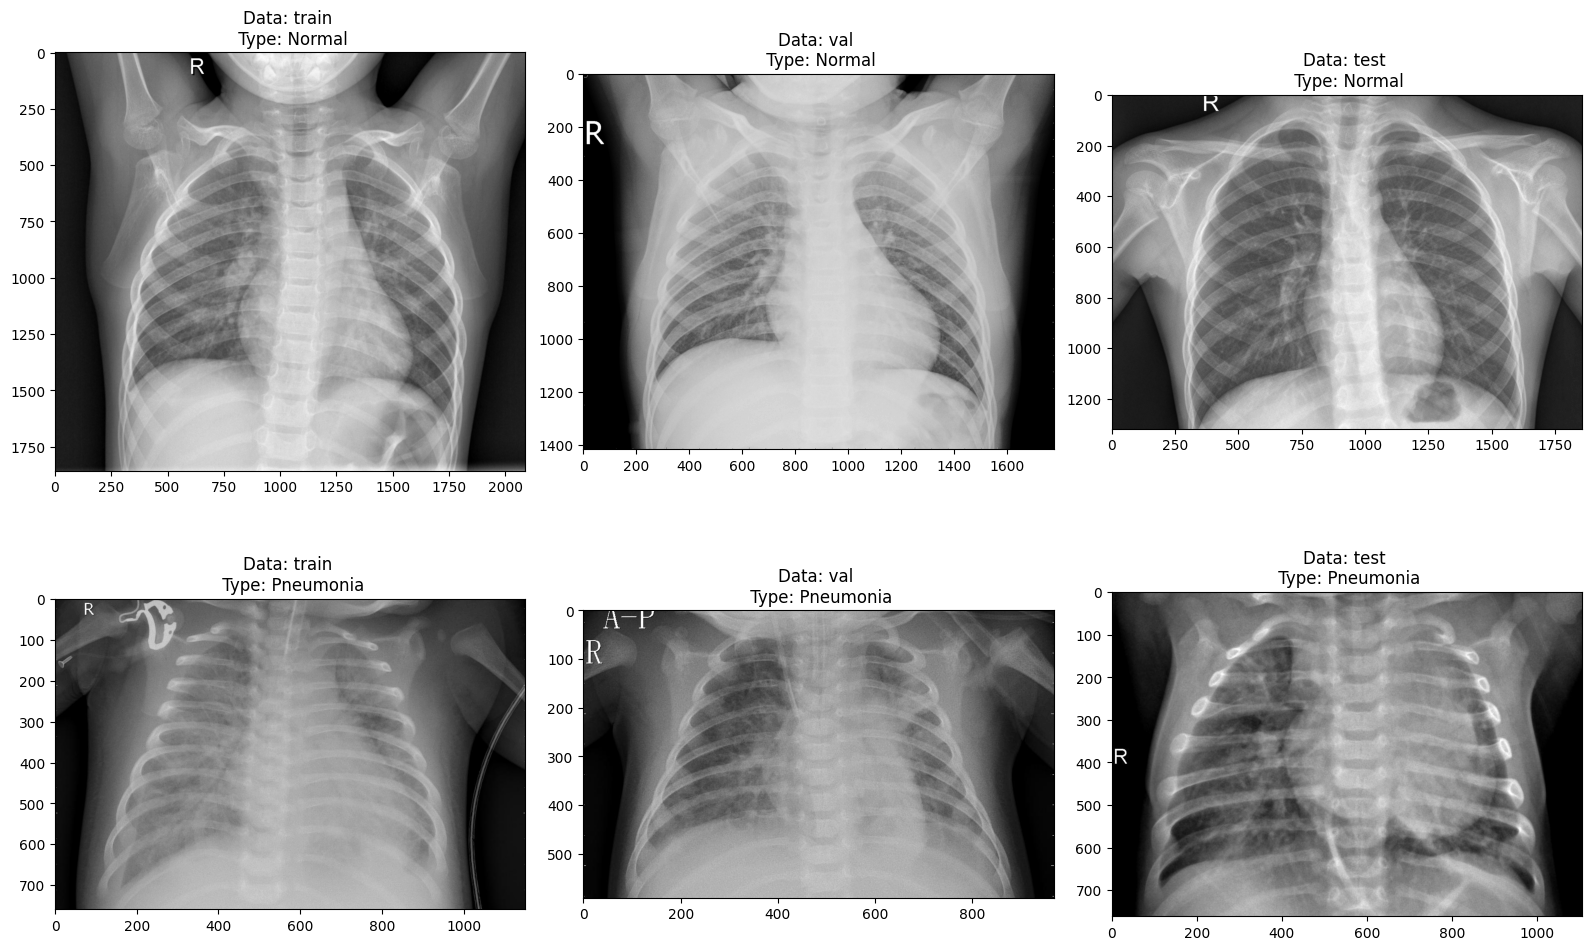

In [4]:
# Looking at one image per class in each dataset type
fig, ax = plt.subplots(2, 3, figsize = (16, 10))
ax = ax.ravel()
plt.tight_layout()

for i, subdir in enumerate(['train', 'val', 'test']):
    image_path = DATA_DIR + subdir
    ax[i].imshow(plt.imread(image_path + '/NORMAL/' + os.listdir(image_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(subdir), fontsize = 12)
    ax[i+3].imshow(plt.imread(image_path + '/PNEUMONIA/' + os.listdir(image_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(subdir), fontsize = 12)

### Prepare Data

In [5]:
# data generator on training dataset, data augmentation applied
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   shear_range=0.2,
                                   vertical_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.3)

# preprocessing the training dataset
training_dataset = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                     classes=DETECTION_CLASSES,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(224, 224))

# data generator on test dataset, data augmentation not applied
# used as validation dataset as the val dir contains only 16 images
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the test dataset (used as validation)
test_dataset = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                                classes=DETECTION_CLASSES,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                target_size=(224, 224))

# data generator on validation dataset, data augmentation not applied
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# preprocessing the validation dataset
val_dataset = test_datagen.flow_from_directory(VAL_DATA_DIR,
                                               classes=DETECTION_CLASSES,
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
# printing the assigned indices for sanity check
print(f'class indices:  {training_dataset.class_indices}')

class indices:  {'NORMAL': 0, 'PNEUMONIA': 1}


### Build `CNN` Model

The following model consists of five `convolution` blocks where after each block, a pooling layer (`max pooling`) is added. The `flattening` layer after the last convolution block prepares the input to be fed into the fully connected layers. In each fully connected layer, `dense` method is used to add a hidden layer where `units` represent the number of nodes/neurons in that layer. The last fully connected layer has two nodes representing the two classes - `pneumonia` and `normal` where the `softmax` activation function (as the two cases are mutually exclusive case) is used. One can also use in this case the `sigmoid` activation function with one unit in the output layer with `binary cross-entropy` loss. 

In [9]:
cnn_model = Sequential()

# First Block of CNN
cnn_model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))

#  Fourth Block of CNN
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Fifth Block of CNN
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(SeparableConv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(rate=0.2))

#  Flatten and Fully Connected Layer
cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation='relu'))
cnn_model.add(Dropout(rate=0.7))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dropout(rate=0.3))

#  Softmax Classifier
cnn_model.add(Dense(units=2, activation='softmax'))

#  Display model
cnn_model.summary()

# compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 separable_conv2d_8 (Separa  (None, 112, 112, 32)      688       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_9 (Separa  (None, 112, 112, 32)      1344      
 bleConv2D)                                                      
                                                      

### Train `CNN` Model


# introducing callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='min',
                           min_delta=0.001,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=MODEL_LOC,  # saves the 'best' model
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

In [11]:
# fit the model
history = cnn_model.fit(training_dataset,
                        steps_per_epoch=len(training_dataset),
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        epochs=EPOCHS,
                        verbose=1)

Epoch 1/20
163/163 [==============================] - 491s 3s/step - loss: 0.3872 - accuracy: 0.8192 - val_loss: 0.7347 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 374s 2s/step - loss: 0.2999 - accuracy: 0.8721 - val_loss: 0.6969 - val_accuracy: 0.3750
Epoch 3/20
163/163 [==============================] - 370s 2s/step - loss: 0.2898 - accuracy: 0.8763 - val_loss: 1.9946 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 345s 2s/step - loss: 0.2431 - accuracy: 0.9007 - val_loss: 2.3802 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 454s 3s/step - loss: 0.2472 - accuracy: 0.8986 - val_loss: 0.8008 - val_accuracy: 0.4631
Epoch 6/20
163/163 [==============================] - 303s 2s/step - loss: 0.2242 - accuracy: 0.9099 - val_loss: 0.5659 - val_accuracy: 0.6827
Epoch 7/20
163/163 [==============================] - 294s 2s/step - loss: 0.1938 - accuracy: 0.9216 - val_loss: 0.5388 - val_accuracy: 0.8349

### Plot Training History

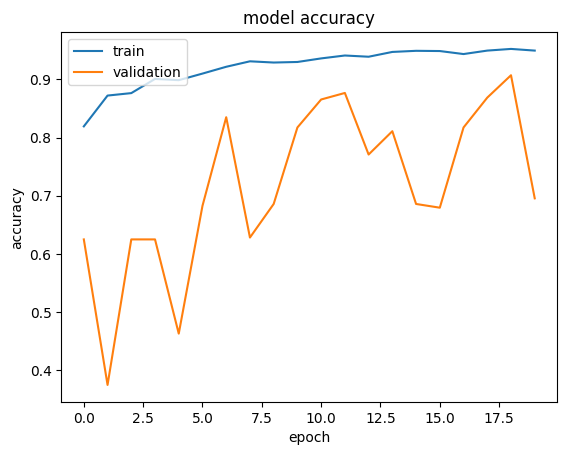

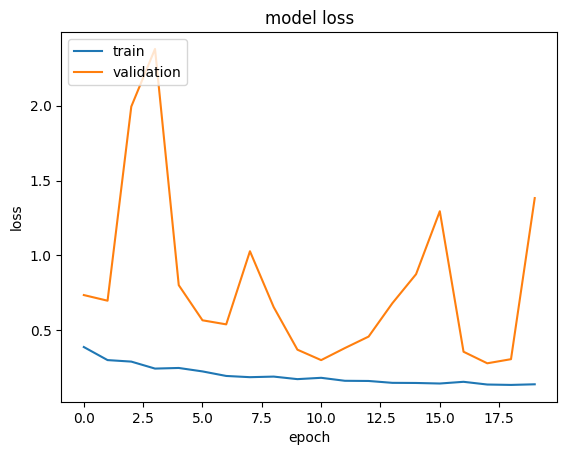

In [12]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model Evaluation

### on test dataset

In [13]:
# load the trained CNN model
cnn_model = load_model(MODEL_LOC)

In [14]:
# storing the true classes of the test dataset
y_true = test_dataset.classes

# predicting the classes of the test dataset
y_pred = cnn_model.predict(test_dataset, steps=len(test_dataset), verbose=1)

# Storing the predicted probability
y_pred_prob = y_pred[:, 1]

# Storing the binary classes for the predictions
y_pred_binary = y_pred_prob > 0.5

20/20 [==============================] - 10s 463ms/step


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
classification_report, roc_auc_score, roc_curve

In [16]:
# confusion matrix for test dataset 
print('\nConfusion Matrix for Test Dataset\n -------------------------')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)


Confusion Matrix for Test Dataset
 -------------------------
[[ 93 141]
 [  6 384]]


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

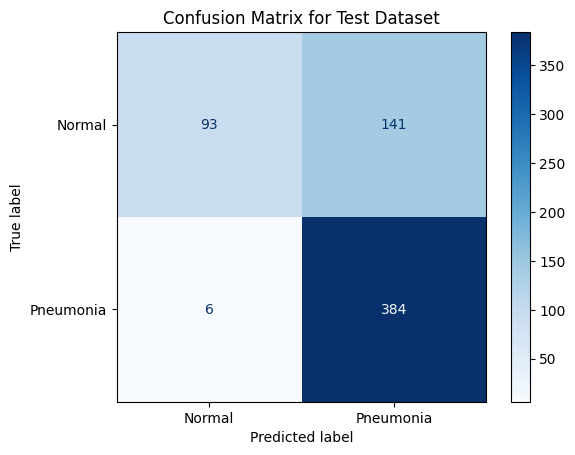

In [17]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')

In [18]:
# classification report
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1_score: 2 tp / (2 tp + fp + fn)
print('\nClassification Report\n -------------------------')
print(classification_report(y_true, y_pred_binary))


Classification Report
 -------------------------
              precision    recall  f1-score   support

           0       0.94      0.40      0.56       234
           1       0.73      0.98      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.76      0.73       624



In [19]:
# ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f'ROC AUC (Test Dataset) {auc:.2}')


ROC AUC (Test Dataset) 0.91


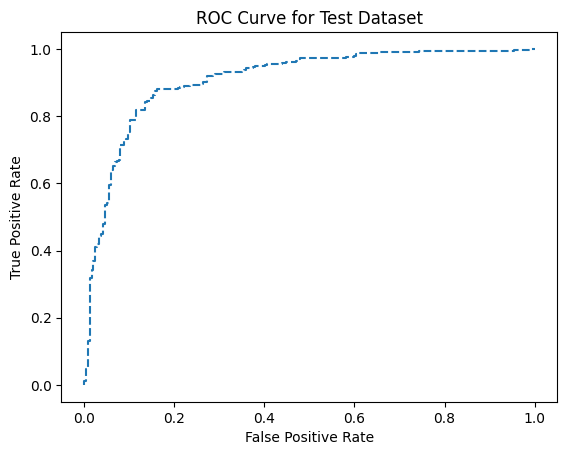

In [20]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)

# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Dataset')
plt.show()

### on validation dataset

In [21]:
# storing the true classes of the test dataset
y_true_val = val_dataset.classes

# predicting the classes of the test dataset
y_pred_val = cnn_model.predict(val_dataset, steps=len(val_dataset), verbose=1)

# Storing the predicted probability
y_pred_val_prob = y_pred_val[:, 1]

# Storing the binary classes for the predictions
y_pred_val_binary = y_pred_val_prob > 0.5

1/1 [==============================] - 0s 325ms/step



Confusion Matrix for Validation Dataset
 -------------------------
[[1 7]
 [0 8]]


Text(0.5, 1.0, 'Confusion Matrix for Validation Dataset')

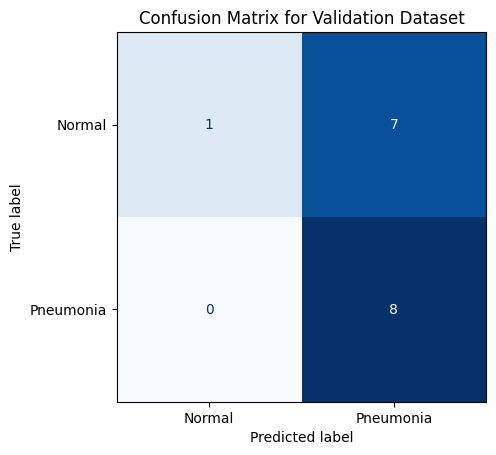

In [22]:
# confusion matrix for validation dataset 
print('\nConfusion Matrix for Validation Dataset\n -------------------------')
cm_val = confusion_matrix(y_true_val, y_pred_val_binary)
print(cm_val)

cm_display_val = ConfusionMatrixDisplay(cm_val, display_labels=['Normal', 'Pneumonia'])
cm_display_val.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Validation Dataset')

In [34]:
import h5py
import joblib
from keras.models import load_model

In [31]:
with h5py.File('pneumonia.h5', 'w') as file:
    joblib.dump(cnn_model, 'pneumonia_model')

In [37]:
cnn_model.save('pneumonia2.h5')

c:\Users\DIVYAM\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
model_path = './pneumonia2.h5'
loaded_model = load_model(model_path)



In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np
example_photo = "E:\Dataset5\person2_bacteria_3.jpeg"
img =image.load_img(example_photo,target_size=(224,224))
arr_img= image.img_to_array(img)
arr_img=np.expand_dims(arr_img,axis=0)
arr_img/=255.0


In [44]:
prediction = loaded_model.predict(arr_img)
idx=np.argmax(prediction)
if(idx==0):
    print("normal")
else:
    print("pneumonia")
print(prediction)

1/1 [==============================] - 0s 64ms/step
pneumonia
[[0.2698223  0.73017764]]
